In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasRegressor

In [3]:
#Obtention des données
DataFrame = pd.read_csv('./Data/UnionData.csv', encoding='latin1', sep = ";")
#Division des données en set d'entraînement et de test
train_dataset = DataFrame.sample(frac=0.8, random_state=0)
test_dataset = DataFrame.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_x50 = train_features.pop('x50') #Entrainement sur x50
test_x50 = test_features.pop('x50') #Test sur x50
test_results = {}

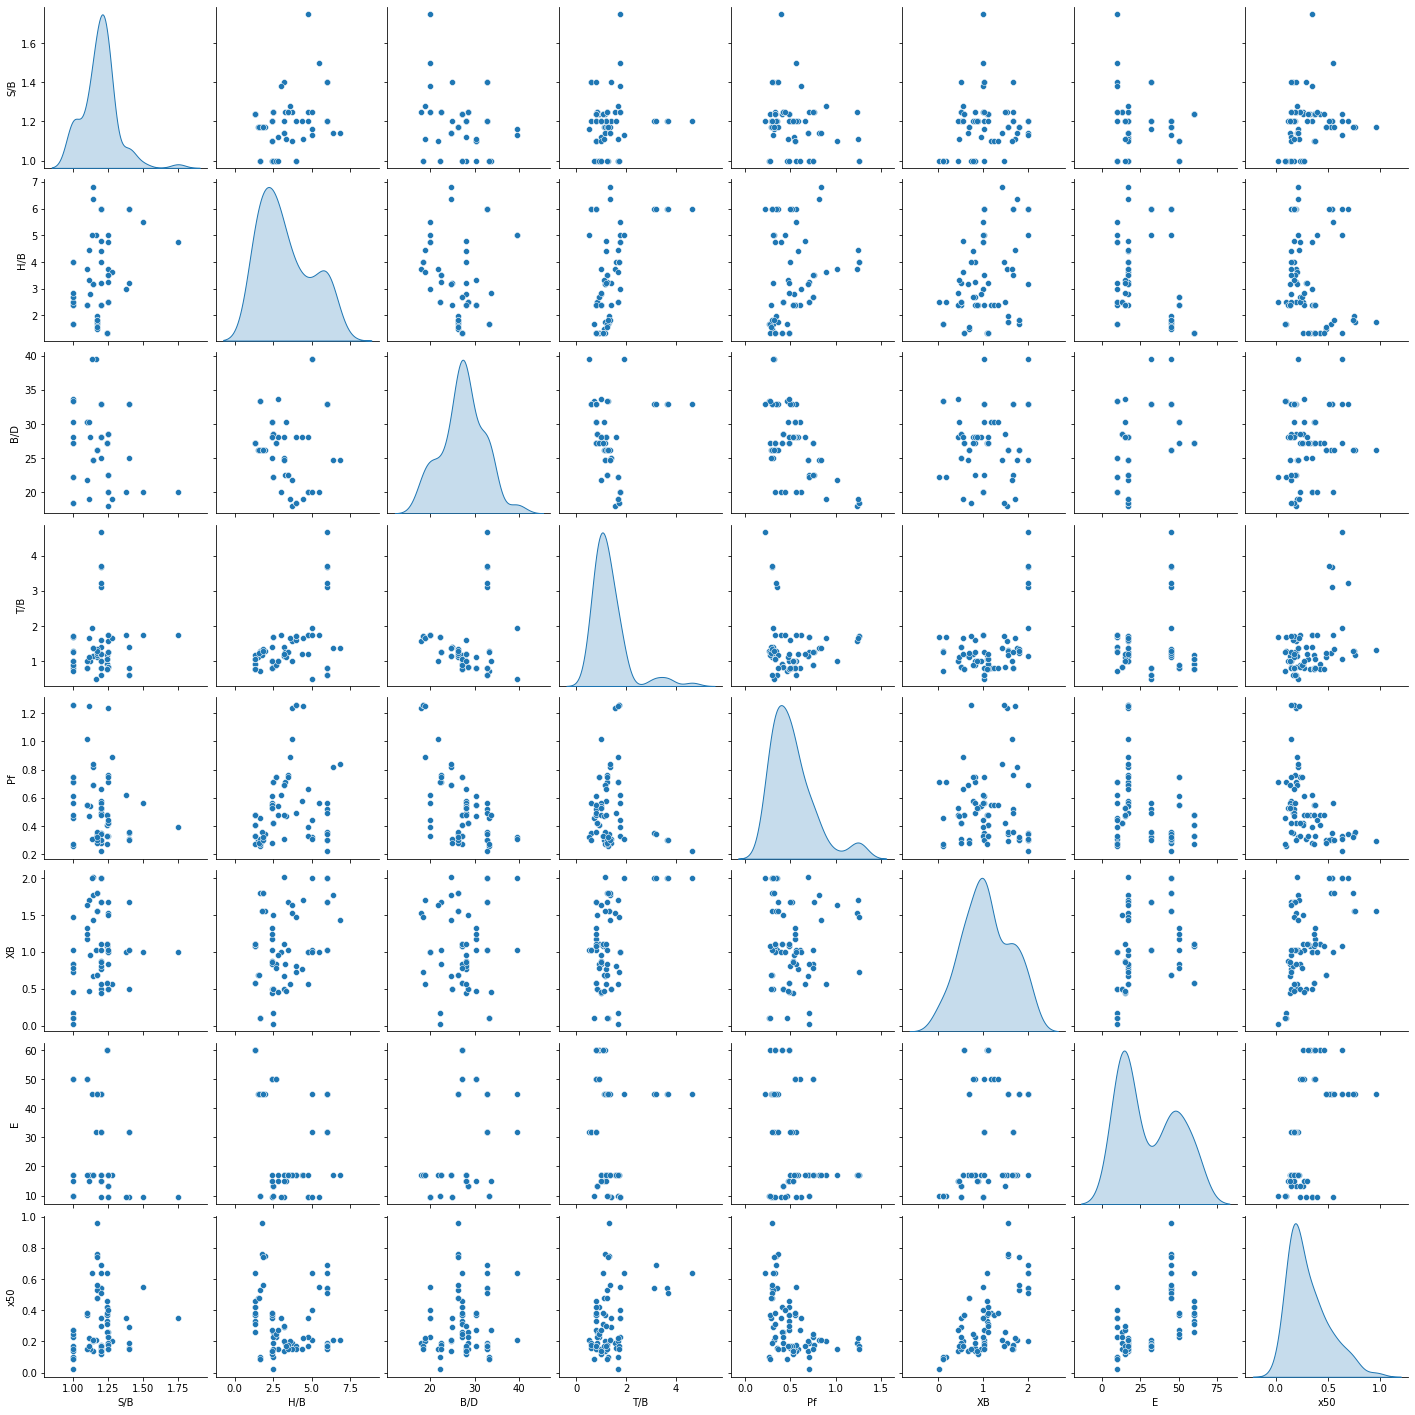

In [4]:
#Distribution conjointe des variables (on cherche des corrélations)
sns.pairplot(train_dataset, diag_kind='kde')

In [4]:
#Informations statistiques de base: 
DataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
S/B,97.0,1.188969,0.116766,1.00,1.14,1.20,1.25,1.75
H/B,97.0,3.345155,1.633681,1.33,1.83,2.83,4.75,6.82
B/D,97.0,27.354948,4.838572,17.98,24.72,27.27,30.30,39.47
T/B,97.0,1.262784,0.673895,0.50,0.83,1.14,1.40,4.67
Pf,97.0,0.529175,0.235455,0.22,0.35,0.48,0.66,1.26
XB,97.0,1.106701,0.532274,0.02,0.73,1.03,1.56,2.35
E,97.0,29.460619,17.878817,9.57,15.00,16.90,45.00,60.00
x50,97.0,0.302577,0.188388,0.02,0.16,0.23,0.40,0.96


# Régressions Deep Learning 

In [29]:
#Les données ont des échelles relativement différentes. On va donc les normaliser.
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


In [30]:
#Visualisation de la progression de l'entrâinement
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [X50]')
  plt.legend()
  plt.grid(True)

In [98]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm, #Couche d'entrée
      layers.Dense(115, activation='relu'), #Couche cachée (cf. l'article de ML)
      layers.Dense(40, activation='relu'), #Couche cachée
      layers.Dense(180, activation='relu'), #Couche cachée
      layers.Dense(35, activation='relu'), #Couche cachée
      layers.Dense(1, activation = 'relu') #Sortie
  ])

  model.compile(loss='mean_squared_error', #Fonction de perte
                optimizer=tf.keras.optimizers.Adam(0.00005))
  return model

## Régression sur x50

In [99]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 7)                15        
 ion)                                                            
                                                                 
 dense_74 (Dense)            (None, 115)               920       
                                                                 
 dense_75 (Dense)            (None, 40)                4640      
                                                                 
 dense_76 (Dense)            (None, 180)               7380      
                                                                 
 dense_77 (Dense)            (None, 35)                6335      
                                                                 
 dense_78 (Dense)            (None, 1)                 36        
                                                     

In [100]:
%%time
history = dnn_model.fit(
    train_features,
    train_x50,
    validation_split=0.2,
    verbose=0, epochs=2000)

Wall time: 7.6 s


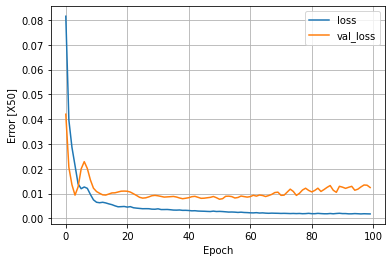

In [101]:
plot_loss(history)

1/1 [==============================] - 0s 254ms/step


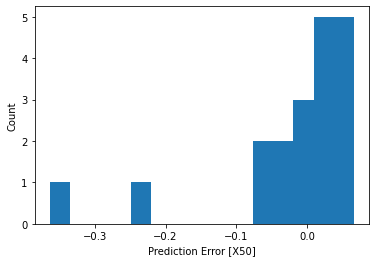

In [13]:
test_predictions = dnn_model.predict(test_features)
y_true = np.array(np.transpose(test_x50)).flatten()
y_pred = test_predictions.flatten()
error_log = y_pred - y_true
plt.hist(error_log, bins= 15)
plt.xlabel('Prediction Error [X50]')
_ = plt.ylabel('Count')

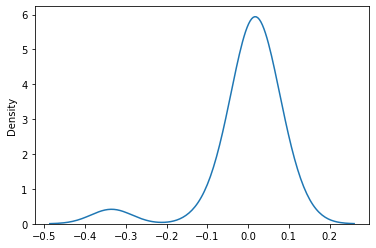

MOYENNE:-0.001668862198528494,Ecart-type0.08848203005366284


In [81]:
sns.kdeplot(error_log)
plt.show()
print(f'MOYENNE:{error_log.mean()},Ecart-type{error_log.std()}')

In [35]:
test_results['DNN'] = dnn_model.evaluate(test_features, test_x50, verbose=0)

# Régression Machine Learning

On doit modifier la forme des dataframes, car scikit attend des vecteurs colonnes. 

In [14]:
train_features_sk = train_dataset.values[:,0:7].reshape(len(train_dataset),7).copy()
test_features_sk = test_dataset.values[:,0:7].reshape(len(test_dataset),7).copy()
train_x50_sk = np.array(train_x50).reshape(len(train_x50),1) #Entrainement sur x50
test_x50_sk = np.array(test_x50).reshape(len(test_x50),1) #Test sur x50

## Régression linéaire

In [16]:
import sklearn.linear_model as lm
from sklearn import metrics

lr = lm.LinearRegression()
lr.fit(train_features_sk, train_x50_sk) 

test_results['Rég.Lin'] = metrics.mean_squared_error(test_x50_sk,lr.predict(test_features_sk))

## Régression ridge linéaire pour x50

Ayant étudié des régressions ridge polynomiale de plusieurs degrés, je me suis aperçu que la régression linéaire donnait les meilleurs résultats (alpha le plus bas, précision la plus élevée, les MSE étaient toutes égales.)

In [17]:
import sklearn.linear_model as lm
import sklearn.metrics as metrics

# on ignore les avertissements "future warning" 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [18]:
ridge1_x50 = lm.RidgeCV(normalize=True, alphas=np.logspace(-5, 5, 11), cv=5)
ridge1_x50.fit(train_features_sk, train_x50_sk)
print("ridge regression, polynome degré 1")
#print(ridge1.intercept_)
#print(ridge1.coef_)
print("alpha sélectionné: %.5f" %ridge1_x50.alpha_)

ridge regression, polynome degré 1
alpha sélectionné: 0.10000


In [19]:
#On met à jour les données du tableau:
test_results['Ridge1'] = metrics.mean_squared_error(test_x50_sk,ridge1_x50.predict(test_features_sk))

## Support Vector Regression

### Pour x50

In [20]:
from sklearn.svm import SVR

#Création du modèle
modelsvr = SVR(kernel="rbf", C=0.744, gamma="auto", epsilon=0.03461)
#Entrainement du modèle.
modelsvr.fit(train_features, train_x50)

test_results['SVR'] = metrics.mean_squared_error(test_x50,modelsvr.predict(test_features))

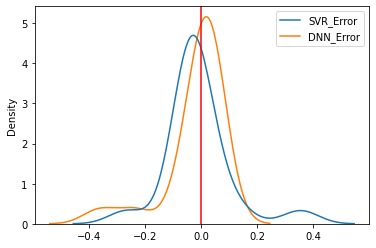

In [21]:
dict_svr_kde = {'SVR_Error': test_x50 - modelsvr.predict(test_features) , 'DNN_Error' : error_log}
SVR_KDE_df = pd.DataFrame(dict_svr_kde)
sns.kdeplot(data = SVR_KDE_df,shade = False, common_norm = False)
plt.axvline(0, color='red')

## XGBoost

In [22]:
import xgboost as xgb
modelxgb = xgb.XGBRegressor(booster = 'gbtree',colsample_bytree=0.87, gamma=0, learning_rate=0.2, max_depth=1, min_child_weight=10, n_estimators=800, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95)

modelxgb.fit(train_features, train_x50)
test_results['XGB'] = metrics.mean_squared_error(test_x50,modelxgb.predict(test_features))

# Comparaison des MSE:

In [23]:
#Examinons maintenant la performance

pd.DataFrame(test_results, index=['Mean squared error [x50]']).T #Correspond à l'erreur de test

,Mean squared error [x50]
Rég.Lin,0.024832
Ridge1,0.024155
SVR,0.012641
XGB,0.017247


Le DNN classique semble avoir la meilleure MSE.

#  Comparaison des précisions:

On va utiliser une validation croisée à 5 plis pour estimer le R², et l'écart type des modèles.

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df = DataFrame.sample(frac=1, random_state = 0).copy()
labels_sk = df.values[:,7].reshape(len(df),1).copy()
features_sk = df.values[:,0:7].reshape(len(df),7).copy()
labels = df.pop('x50')
features = df
features2 = poly2.fit_transform(features_sk)


Accuracy = []
Std = []

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
#DNN X50
create_model = build_and_compile_model(normalizer)
model = KerasRegressor(model=create_model, epochs=2000, verbose=0)
# evaluate using 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
scores_dnn = cross_val_score(model, features, labels, cv=5)
Accuracy.append(scores_dnn.mean())
Std.append(scores_dnn.std())


#RIDGE 1 X50
scores_ridge1 = cross_val_score(ridge1_x50, features_sk, labels_sk, cv=5)
Accuracy.append(scores_ridge1.mean())
Std.append(scores_ridge1.std())


#SVR X50:
scores_svr = cross_val_score(modelsvr, train_features, train_x50, cv=5)
Accuracy.append(scores_svr.mean())
Std.append(scores_svr.std())



#XGBOOST X50:
scores_xgb= cross_val_score(modelxgb, train_features, train_x50, cv=5)
Accuracy.append(scores_xgb.mean())
Std.append(scores_xgb.std())

#REGRESSION LINEAIRE
scores_lr= cross_val_score(lr, features_sk, labels_sk, cv=5)
Accuracy.append(scores_lr.mean())
Std.append(scores_lr.std())




INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmp1_3ygutw\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmpg7vhpffi\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmpw0lshol8\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmpq3uhrnw2\assets
INFO:tensorflow:Assets written to: C:\Users\victo\AppData\Local\Temp\tmptfy9gpia\assets


In [55]:
test_results_df = pd.DataFrame(test_results, index=['Mean squared error [x50]']).T
test_results_df['Accuracy'] = np.array(Accuracy)
test_results_df['Std'] = np.array(Std)
test_results_df

,Mean squared error [x50],Accuracy,Std
Rég.Lin,0.024832,0.668353,0.131616
Ridge1,0.024155,0.483206,0.199264
SVR,0.012641,0.728896,0.125059
XGB,0.017247,0.631118,0.259074
DNN,0.017548,0.478421,0.212597


__DNN__ et __SVR__ semblent donc être les meilleurs candidats.

# Dropout de Monte Carlo (mesure de l'incertitude)

In [24]:
class MCDropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [25]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for i in range(num_samples)]
    return np.hstack(preds)

def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [26]:
def build_and_compile_monte_carlo_model(norm):
  model = keras.Sequential([
      norm, #Couche d'entrée
      MCDropout(0.1),
      layers.Dense(115, activation='relu'), #Couche cachée (cf. l'article de ML)
      MCDropout(0.1),
      layers.Dense(40, activation='relu'), #Couche cachée
      MCDropout(0.1),
      layers.Dense(180, activation='relu'), #Couche cachée
      MCDropout(0.1),
      layers.Dense(35, activation='relu'), #Couche cachée
      MCDropout(0.1),
      layers.Dense(1) #Sortie
  ])


  model.compile(loss='mean_squared_error', #Fonction de perte
                optimizer=tf.keras.optimizers.Adam(0.00005))
  return model

In [27]:
dnn_monte_carlo_model = build_and_compile_monte_carlo_model(normalizer)
dnn_monte_carlo_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 mc_dropout (MCDropout)      (None, 7)                 0         
                                                                 
 dense_5 (Dense)             (None, 115)               920       
                                                                 
 mc_dropout_1 (MCDropout)    (None, 115)               0         
                                                                 
 dense_6 (Dense)             (None, 40)                4640      
                                                                 
 mc_dropout_2 (MCDropout)    (None, 40)                0         
                                                      

In [28]:
%%time
history = dnn_monte_carlo_model.fit(
    train_features,
    train_x50,
    validation_split=0.2,
    verbose=0, epochs=2000)

Wall time: 1min 10s


## Densité pour la première valeur de test de x50 DNN


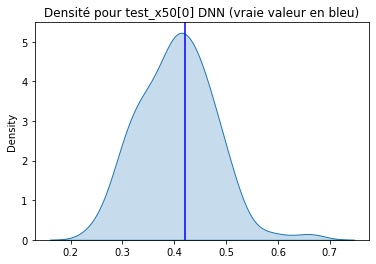

In [36]:
y_pred_dist = predict_dist(test_features, dnn_monte_carlo_model, 100)
y_pred = predict_point(test_features, dnn_monte_carlo_model, 100)

sns.kdeplot(y_pred_dist[0], shade=True)
plt.axvline(np.array(test_x50)[0], color='blue')
plt.title("Densité pour test_x50[0] DNN (vraie valeur en bleu)")
plt.show()

## Estimation de densité par noyau 

<AxesSubplot:ylabel='Density'>

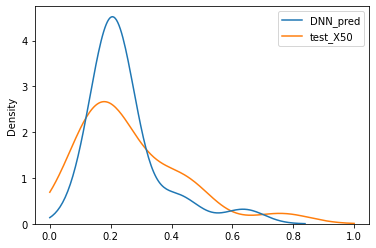

In [115]:
dict_DNN_kde = {'DNN_pred': y_pred, 'test_X50' : test_x50}
DNN_KDE_df = pd.DataFrame(dict_DNN_kde)
sns.kdeplot(data = DNN_KDE_df,shade = False, clip = (0,1),common_norm = False)

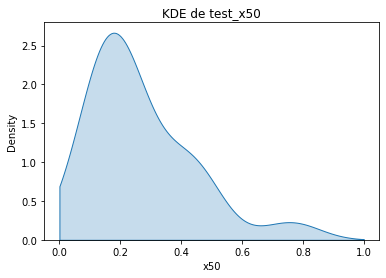

In [40]:
sns.kdeplot(test_x50, shade = True, clip = (0,1))
plt.title("KDE de test_x50")
plt.show()

## Densité pour la première valeur de test de x50 SVR

<AxesSubplot:ylabel='Density'>

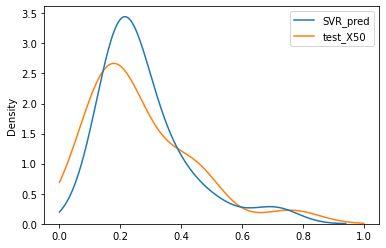

In [41]:
dict_svr_kde = {'SVR_pred': modelsvr.predict(test_features), 'test_X50' : test_x50}
SVR_KDE_df = pd.DataFrame(dict_svr_kde)
sns.kdeplot(data = SVR_KDE_df,shade = False, clip = (0,1), common_norm = False)

# MC Dropout, prédiction de la moyenne des sorties:

In [37]:
test_results['MC Dropout'] = metrics.mean_squared_error(test_x50, y_pred)

In [38]:
pd.DataFrame(test_results, index=['Mean squared error [x50]']).T

,Mean squared error [x50]
Rég.Lin,0.024832
Ridge1,0.024155
SVR,0.012641
XGB,0.017247
DNN,0.017548
MC Dropout,0.020217
